# Importing the data

In [ ]:
#importing all libraries
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
import hashlib
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
#downloading the dataset from kaggle
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 86% 128M/149M [00:00<00:00, 215MB/s]
100% 149M/149M [00:00<00:00, 218MB/s]


In [ ]:
#unzip dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain-tumor-mri-dataset

# Exploratory Data Analysis (EDA)

### Displaying the first five images to see what our dataset looks like



We notice that our image sizes seems inconsistent based on the sizes of the first five images from each class

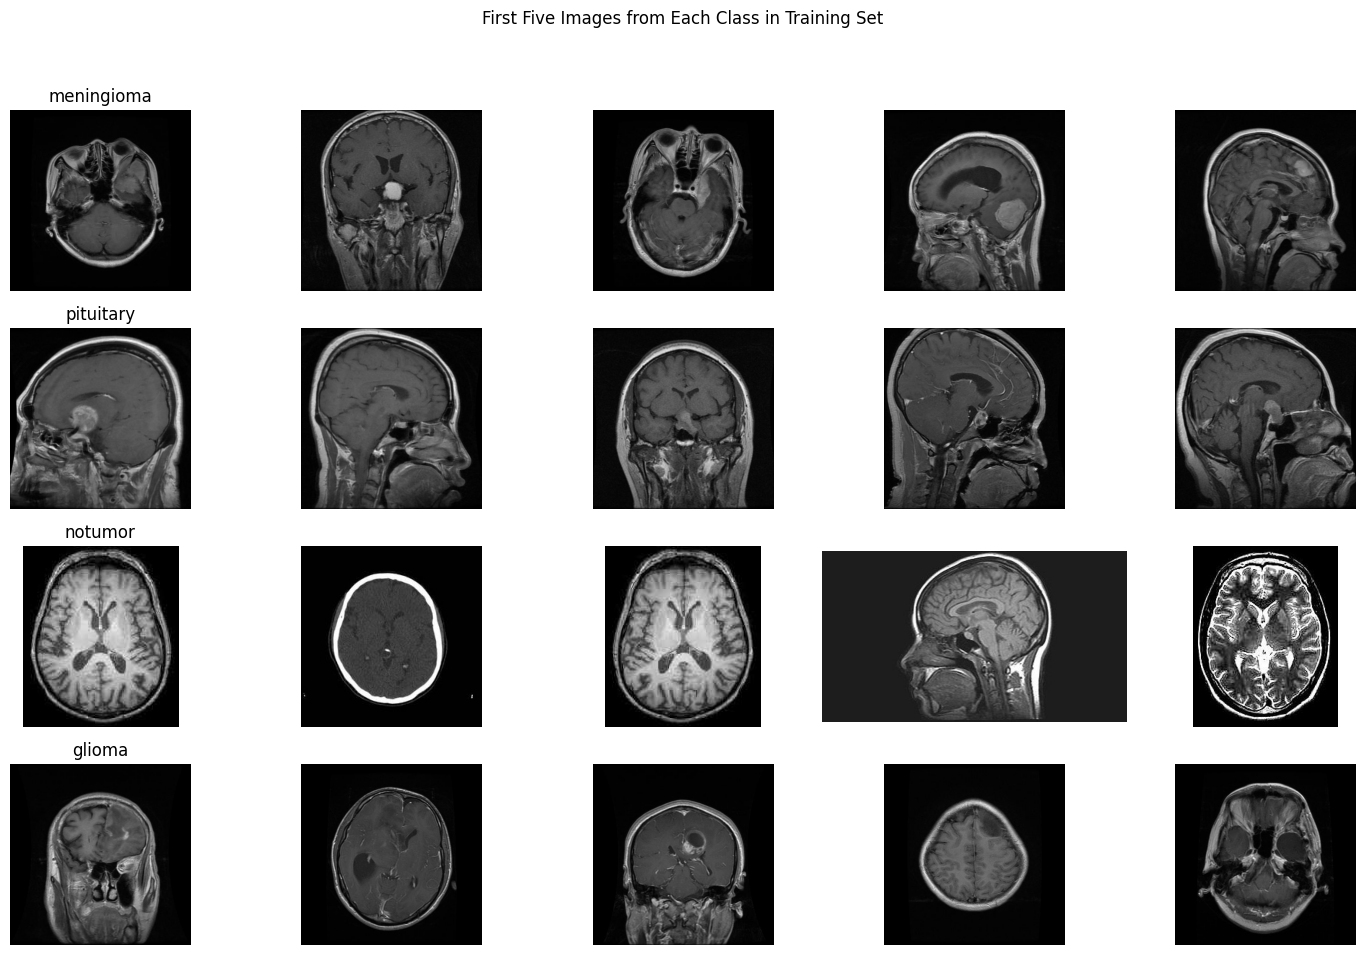

In [ ]:
#these are the paths for the training and testing directories
training_path = 'brain-tumor-mri-dataset/Training'
testing_path = 'brain-tumor-mri-dataset/Testing'

#displaying first five images from each class in the training set
classes = os.listdir(training_path)

#picked the training datatset to plot because the data was pre-split between test and train
fig, axs = plt.subplots(len(classes), 5, figsize=(15, 10))
fig.suptitle('First Five Images from Each Class in Training Set')

#iterate through every image and plot the first five images from each class
for i, class_name in enumerate(classes):
    class_path = os.path.join(training_path, class_name)
    images = os.listdir(class_path)[:5]

    for j, image_name in enumerate(images):
        image_path = os.path.join(class_path, image_name)
        img = mpimg.imread(image_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].axis('off')
        if j == 0:
            axs[i, j].set_title(class_name)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Reviewing the size of our dataset

In [ ]:
#creating a function to count how many images there are in each class within the specified path
def count_images_in_classes(path):
    """
    Counts the number of images in each class directory within the given path.

    Args:
        path (str): The directory path containing subdirectories for each class.

    Returns:
        dict: A dictionary where the keys are class names and the values are the number of images in each class.
    """
    class_counts = {}
    for class_name in os.listdir(path):
        class_path = os.path.join(path, class_name)
        class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

#count the images in the training and testing paths
training_counts = count_images_in_classes(training_path)
testing_counts = count_images_in_classes(testing_path)

#calculate the total number of images in training and testing
train_sum = sum(training_counts.values())
test_sum = sum(testing_counts.values())

#calculate the original train/test split percentage
original_train_test_split = train_sum / (test_sum + train_sum) * 100

#print the results
print('Total number of images of dataset:', train_sum + test_sum)
print('Total training data size:', train_sum)
print('Total testing data size:', test_sum)
print('Training Counts:', training_counts)
print('Testing Counts:', testing_counts)
print('Original Train Split= ', original_train_test_split)
print('Original Test Split= ',(100-(original_train_test_split)))

Total number of images of dataset: 7023
Total training data size: 5712
Total testing data size: 1311
Training Counts: {'meningioma': 1339, 'pituitary': 1457, 'notumor': 1595, 'glioma': 1321}
Testing Counts: {'meningioma': 306, 'pituitary': 300, 'notumor': 405, 'glioma': 300}
Original Train Split=  81.33276377616403
Original Test Split=  18.66723622383597


Original test/train split is 81/18~

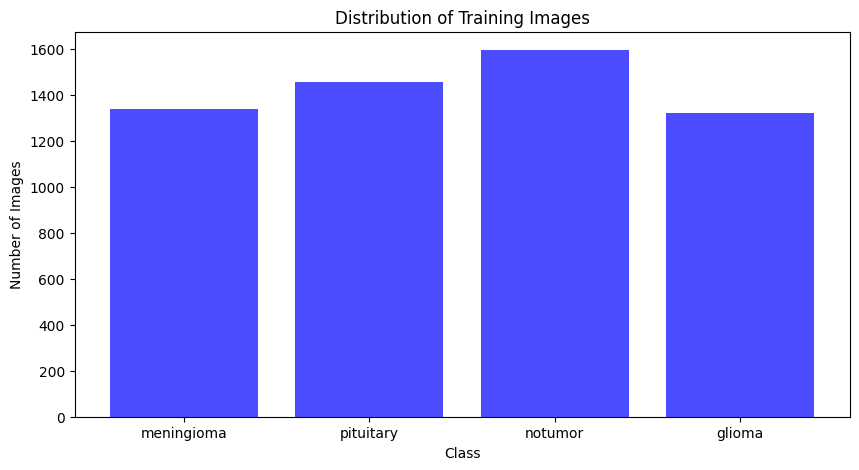

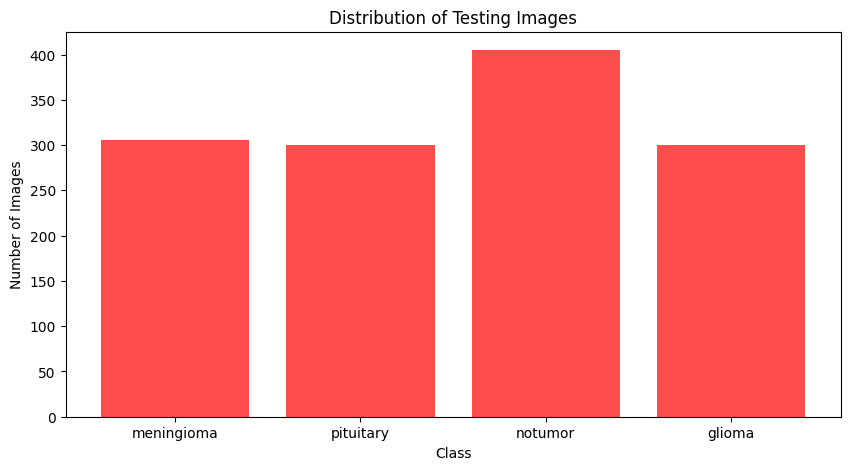

In [ ]:
#distribution of trianing images
plt.figure(figsize=(10, 5))
plt.bar(training_counts.keys(), training_counts.values(), color='b', alpha=0.7)
plt.title('Distribution of Training Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

#distribution of test images
plt.figure(figsize=(10, 5))
plt.bar(testing_counts.keys(), testing_counts.values(), color='r', alpha=0.7)
plt.title('Distribution of Testing Images')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()


### Checking for duplicates in test and train datasets

1) lists all the labels in the training directory.

2) compute a unique hash for each file -> list all JPEG files and their hashes -> count the total number of files in a directory -> remove duplicate files based on their hashes.

3) counts and prints the number of files in both directories and creates a dictionary to store the hashes of the files, lists all files to populate this dictionary, and removes any duplicates.

In [ ]:
#get the list of labels (subdirectories) in the training directory
training_directory = os.path.join(training_path)
testing_directory = os.path.join(testing_path)
labels = os.listdir(training_directory)


def compute_file_hash(file_path):
    """
    Computes the MD5 hash of a file.

    Args:
        file_path (str): Path to the file.

    Returns:
        str: The MD5 hash of the file.
    """
    hasher = hashlib.md5()  # Create a new MD5 hash object
    with open(file_path, 'rb') as file:  # Open the file in binary read mode
        buffer = file.read()  # Read the entire file into memory
        hasher.update(buffer)  # Update the hash object with the file contents
    return hasher.hexdigest()  # Return the hexadecimal representation of the hash

def list_files_by_hash(hash_dict):
    """
    Lists all JPEG files in the training and testing directories, computes their hashes, and stores them in a dictionary.

    Args:
        hash_dict (dict): Dictionary to store file hashes and their paths.
    """
    for dataset_path in [training_directory, testing_directory]:
        for label in labels:
            folder_path = os.path.join(dataset_path, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):  # Only consider JPEG files
                        file_path = os.path.join(root, file)
                        file_hash = compute_file_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]

def count_files(directory_path):
    """
    Counts the total number of files in a directory and its subdirectories.

    Args:
        directory_path (str): Path to the directory.

    Returns:
        int: Total number of files in the directory.
    """
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

def remove_duplicates(hash_dict):
    """
    Removes duplicate files based on their hashes.

    Args:
        hash_dict (dict): Dictionary of file hashes and their paths.
    """
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:  # If more than one file has the same hash
            for file_path in file_paths[1:]:  # Keep the first file, remove the rest
                print(f"Removing duplicate (hash: {hash_value}): {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates removed: {duplicate_count}")

#count and display the number of files before removing duplicates
training_file_count_before = count_files(training_directory)
testing_file_count_before = count_files(testing_directory)

print(f"This is the training path size before removing duplicates: {training_file_count_before}")
print(f"This is the testing path size before removing duplicates: {testing_file_count_before}")

#create a dictionary to store file hashes
hash_dict = {}

#list all files and compute their hashes
list_files_by_hash(hash_dict)

#remove duplicates
remove_duplicates(hash_dict)

#count and display the number of files after removing duplicates
training_file_count_after = count_files(training_directory)
testing_file_count_after = count_files(testing_directory)

print(f"This is the training path size after removing duplicates: {training_file_count_after}")
print(f"This is the testing path size after removing duplicates: {testing_file_count_after}")



This is the training path size before removing duplicates: 5712
This is the testing path size before removing duplicates: 1311
Removing duplicate (hash: af3a4cf5d54bd454b733bfe3d2177b4a): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0366.jpg
Removing duplicate (hash: af3a4cf5d54bd454b733bfe3d2177b4a): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0176.jpg
Removing duplicate (hash: b0481c04cf82055b53bed325556f744e): brain-tumor-mri-dataset/Testing/meningioma/Te-me_0135.jpg
Removing duplicate (hash: ab525628d00898aa6b1088d9c1d5a785): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0175.jpg
Removing duplicate (hash: 333ca271271562e025951545e76a8b0b): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0249.jpg
Removing duplicate (hash: 832c3e0243e8fafe4313d899e233285d): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0617.jpg
Removing duplicate (hash: a501e6ea3748d3aebea8e8735268ec5b): brain-tumor-mri-dataset/Training/meningioma/Tr-me_0238.jpg
Removing duplicate (hash: 3cb1d659

In [ ]:
# Count files per label after removing duplicates
#show number of files per label
training_counts = count_images_in_classes(training_path)
testing_counts = count_images_in_classes(testing_path)

print('Training Counts:', training_counts)
print('Testing Counts:', testing_counts)

#now lets reconfirm the train/test split
new_train_test_split = training_file_count_after / (training_file_count_after + testing_file_count_after)

print('Training% = ', new_train_test_split)
print('Testing% = ',(100/100-(new_train_test_split)))

Training Counts: {'meningioma': 1333, 'pituitary': 1445, 'notumor': 1422, 'glioma': 1321}
Testing Counts: {'meningioma': 302, 'pituitary': 295, 'notumor': 309, 'glioma': 299}
Training% =  0.820844484091585
Testing% =  0.17915551590841505


Initially the training dataset contained a total of 5712 files, with the following counts per label: glioma (1321), meningioma (1339), pituitary (1457), and notumor (1595). Post-duplicate removal, the total count for the training dataset decreased to 5521 files, which included the the removal of 191 duplicate files. The updated counts for the training dataset are: glioma (1321), meningioma (1333), pituitary (1445), and notumor (1422). Similarly, the testing dataset originally comprised 1311 files, with counts per label as follows: glioma (300), meningioma (306), pituitary (300), and notumor (405). After duplicates were removed, the testing dataset was reduced to 1205 files, reflecting the elimination of 106 duplicates. The revised counts for the testing dataset are: glioma (299), meningioma (302), pituitary (295), and notumor (309)

#Data preprocessing

Here we are preprocessing our dataset. this is what the code does-

1) loads and resizes images from specified training and testing directories, assigning labels based on subdirectory names.

2) encodes  labels into integers and shuffles the training data.

3) training data is split into training and validation sets, with the training set augmented by flipping images horizontally.

4) images are normalized and, for the training set, brightness and contrast adjustments are applied.


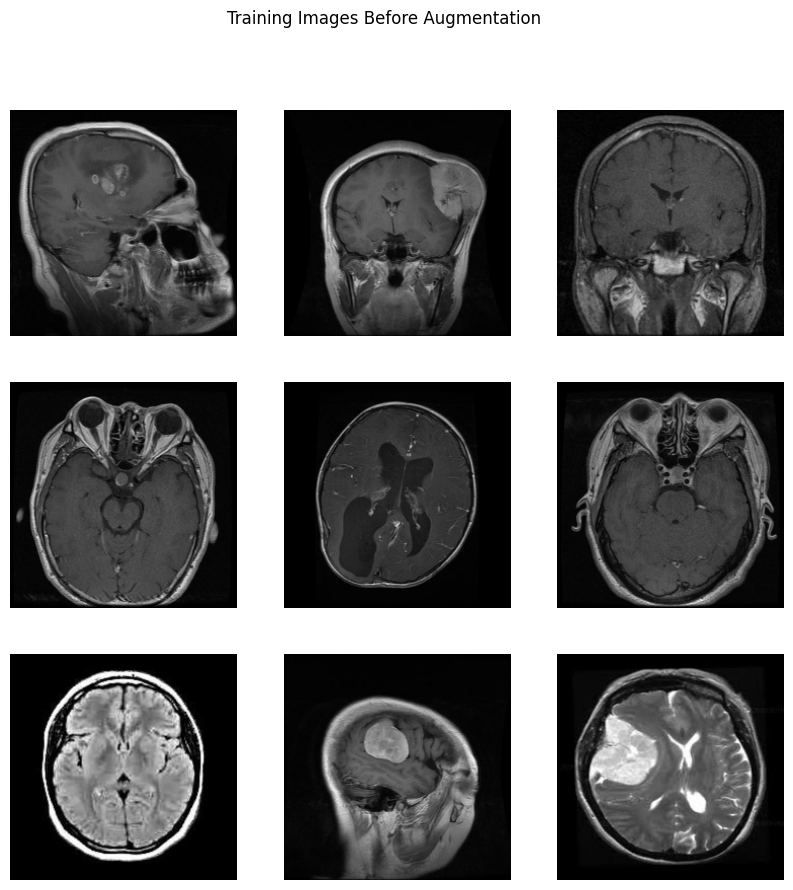

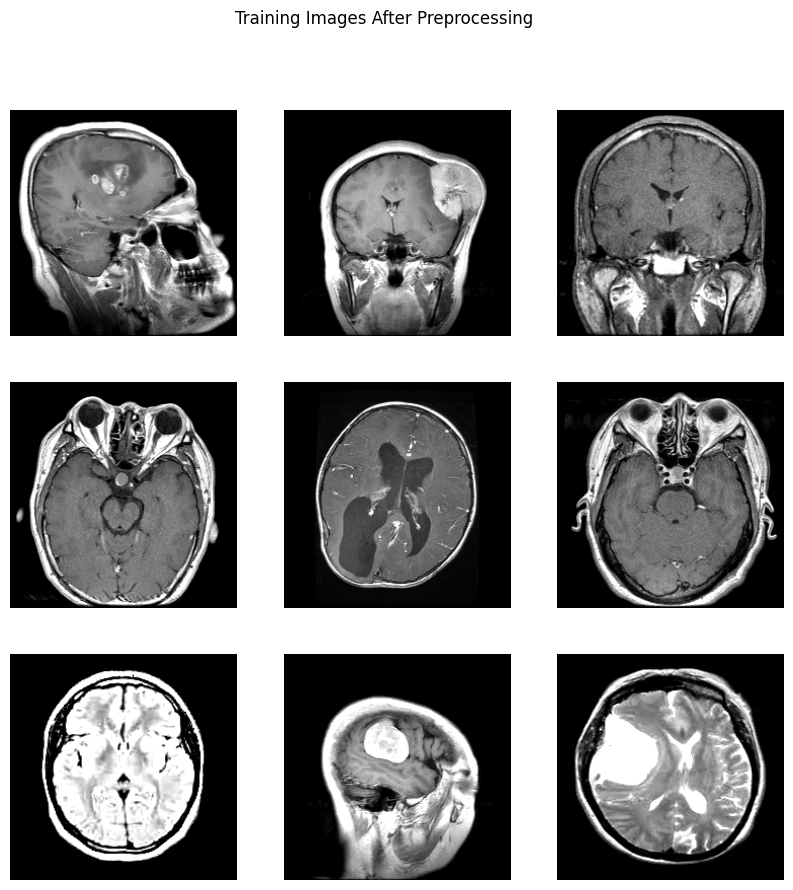

Training set size: 8280 images
Validation set size: 1381 images
Testing set size: 1205 images


In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def load_images_from_folder(folder, target_size=(224, 224)):
    """
    Loads and resizes images from a specified folder, assigning labels based on tumor type.

    Args:
        folder (str): Path to the main folder containing subdirectories for each label.
        target_size (tuple): Desired image size as (width, height). Default is (224, 224).

    Returns:
        np.ndarray: Array of images.
        np.ndarray: Array of labels corresponding to the images.
    """
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img_path = os.path.join(label_path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, target_size)  # Resize image to target size
                    images.append(img)
                    labels.append(label)
    return np.array(images), np.array(labels)

def preprocess_data_part2(training_path, testing_path):
    """
    Preprocesses data by loading images, encoding labels, shuffling, splitting into training and validation sets,
    augmenting the training data, normalizing images, and applying brightness and contrast adjustments.

    Args:
        training_path (str): Path to the training data folder.
        testing_path (str): Path to the testing data folder.

    Returns:
        tuple: Preprocessed training, validation, and testing sets along with original training images,
               training indices, and label encoder.
    """
    #load images and labels from the training and testing paths
    X_train_raw, Y_train_raw = load_images_from_folder(training_path)
    X_test, Y_test = load_images_from_folder(testing_path)

    #encode labels to integers
    label_encoder = LabelEncoder()
    Y_train_raw = label_encoder.fit_transform(Y_train_raw)
    Y_test = label_encoder.transform(Y_test)

    #shuffle the training data
    train_indices = np.arange(len(X_train_raw))
    np.random.shuffle(train_indices)
    X_train_shuffled = X_train_raw[train_indices]
    Y_train_shuffled = Y_train_raw[train_indices]

    #split the training data into training (75%) and validation (25%) sets
    X_train, X_val, Y_train, Y_val = train_test_split(X_train_shuffled, Y_train_shuffled, test_size=0.25, random_state=42)

    #save a copy of the training images before augmentation
    X_train_before_aug = X_train.copy()

    #augment training data by flipping images horizontally
    augmented_train_images = tf.image.flip_left_right(X_train)
    X_train = np.concatenate((X_train, augmented_train_images), axis=0)
    Y_train = np.concatenate((Y_train, Y_train), axis=0)

    #normalize images by dividing by 255.0
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    #applying brightness and contrast adjustments to the training set only
    X_train = tf.image.adjust_brightness(X_train, delta=0.1)
    X_train = tf.image.adjust_contrast(X_train, contrast_factor=2)

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, X_train_before_aug, train_indices, label_encoder

def show_images(images, title):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

training_path = 'brain-tumor-mri-dataset/Training'
testing_path = 'brain-tumor-mri-dataset/Testing'

#preprocess the data
X_train, Y_train, X_val, Y_val, X_test, Y_test, X_train_before_aug, train_indices, label_encoder = preprocess_data_part2(training_path, testing_path)

#show some examples before preprocessing (using the shuffled indices to match)
show_images(X_train_before_aug[:9], "Training Images Before Augmentation")

#show some examples after preprocessing
show_images(X_train.numpy()[:9], "Training Images After Preprocessing")


print(f"Training set size: {len(X_train)} images")
print(f"Validation set size: {len(X_val)} images")
print(f"Testing set size: {len(X_test)} images")


In [ ]:
#checking labels in the y_train
unique_labels = np.unique(Y_train)
print(unique_labels)

#check which label corresponds to what - havent changed the label for notumor
label_names = label_encoder.classes_
print(label_names)

[0 1 2 3]
['glioma' 'meningioma' 'notumor' 'pituitary']


In [ ]:
#Printing shapes just in case
print(f"X_train shape {X_train.shape}")
print(f"y_train shape {Y_train.shape}")
print(f"X_val shape {X_val.shape}")
print(f"y_val shape {Y_val.shape}")
print(f"X_test shape {X_test.shape}")
print(f"y_test shape {Y_test.shape}")

X_train shape (8280, 224, 224, 3)
y_train shape (8280,)
X_val shape (1381, 224, 224, 3)
y_val shape (1381,)
X_test shape (1205, 224, 224, 3)
y_test shape (1205,)


# Creating a baseline

In [ ]:
#here we have early stopping, which checks the validation accuracy and if the model doesn't improve for 4 consecutive epochs, it stops training.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    #monitor the validation accuracy
    verbose=1,
    #set to 4
    patience=4,
    #looks for the maximum value of validation accuracy
    mode='max',
    #After stopping, it goes back to the best model weights it had during training
    restore_best_weights=True
)

#using conv2d model
model1 = tf.keras.Sequential([
    #use 12 filters, 4x4 grid of pixels
    tf.keras.layers.Conv2D(filters=12, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=(224, 224, 3), name='conv_1'),
    #reduce size of image
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    #prevet overfitting by addding
    tf.keras.layers.Dropout(0.3),
    #flatted for dense layer
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation='softmax')
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy', #labels are not one hot encoded so i used sparse categorical crossentropy
               metrics=['accuracy'])

model1.summary()

history1 = model1.fit(X_train, Y_train, epochs=20, validation_data=(X_val, Y_val), callbacks=[early_stopping])

# Evaluate the model
_, train_accuracy = model1.evaluate(X_train, Y_train)
print('Training Accuracy: {}'.format(train_accuracy))

_, val_accuracy = model1.evaluate(X_val, Y_val)
print('Validation Accuracy: {}'.format(val_accuracy))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 224, 224, 12)      588       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 12)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 112, 112, 12)      0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 4)                 602116    
                                                                 
Total params: 602704 (2.30 MB)
Trainable params: 602704 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [ ]:
model1_accuracy = model1.evaluate(X_test, Y_test)
print('Model 1 Accuracy:', model1_accuracy)

38/38 [==============================] - 1s 24ms/step - loss: 0.3485 - accuracy: 0.8871
Model 1 Accuracy: [0.34849855303764343, 0.8871369361877441]


38/38 [==============================] - 1s 23ms/step


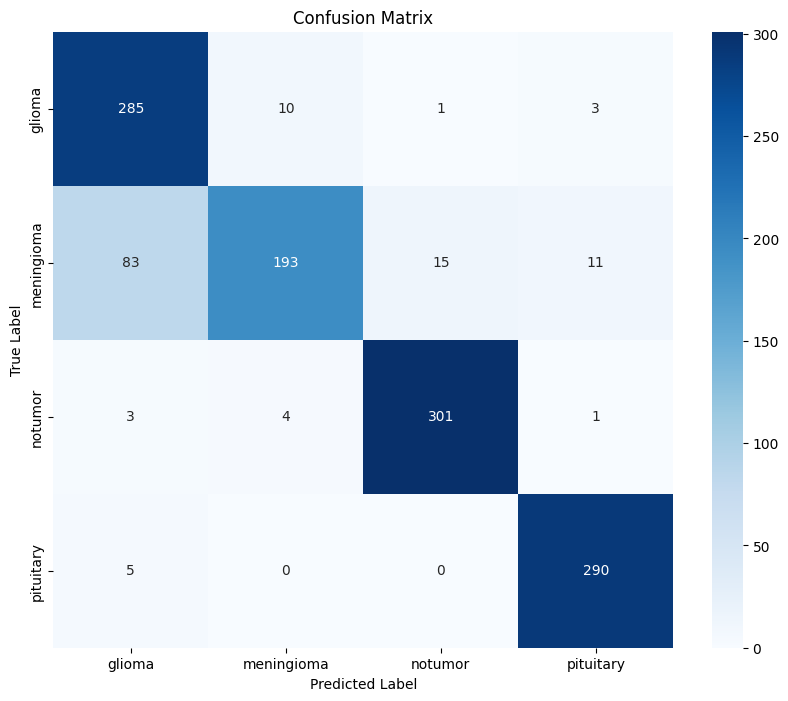

In [ ]:
#confusion matrix

predictions = model1.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)  # Convert one-hot predictions to integer labels

conf_matrix = confusion_matrix(Y_test, predicted_labels)
class_names = label_encoder.classes_


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()